<a href="https://colab.research.google.com/github/yadomkar/SyllabusFairness/blob/main/Syllabus_Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive and Navigating to folder
Make sure BE_Project folder is uploaded to your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My Drive/BE_Project/BE_Project/Final_Project

/content/drive/My Drive/BE_Project/BE_Project/Final_Project


# Downloading Dependencies

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

import nltk
nltk.download("popular")

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144795 sha256=c1402bbe5301958f36f4bcc7639c3eed4328d9eb09db5f4ffa9d461183864ad3
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nlt

True

# Module 1: Knowledge Graph
Contains all the related functions

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import copy
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import difflib as dl
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:


# set subject

def set_subject(subject_name):

    global subject
    subject = subject_name


# In[3]:


# Syllabus CSV file to Syllabus DataFrame

def create_syllabus_df(filename, totalmarks=120):

    file = open(filename,'r')
    text = file.read()
    text = text.replace('\xad', ' ')
    l = text.split("\n")
    syl = pd.DataFrame(l)
    csyl = copy.deepcopy(syl)

    #1
    for i in range(len(syl)):
        csyl[0][i] = csyl[0][i].split(",")
        syl[0][i] = csyl[0][i][0]
    time = []
    for i in range(len(syl)):
        csyl[0][i].pop(0)
        time.append(csyl[0][i].pop(len(csyl[0][i])-1))

    syl[1] = csyl[0]
    temp = pd.DataFrame(time)
    syl[2] = temp[0]

    #2
    syl.rename(columns={0:'Module',1:'Topic',2:'Weightage'}, inplace=True)
    syl['Weightage'] = syl['Weightage'].astype(int)
    syl['Weightage'] = syl['Weightage']*totalmarks/syl['Weightage'].sum()

    #3
    for i in range(len(syl)):
        for j in range(len(syl['Topic'][i])):
            syl['Topic'][i][j] = syl['Topic'][i][j].split("+")

    return syl


# In[4]:


# Syllabus DataFrame to Graph

def create_graph(syllabus_df):
    global G
    syl = syllabus_df
    totalmarks = int(syl['Weightage'].sum())
    G = nx.DiGraph(edge_attr = True)
    G.add_node(subject,node_bucket= 0, overflow_bucket= 0, max_marks = totalmarks)

    for i in range(len(syl)):
        G.add_node(syl['Module'][i],node_bucket= 0, overflow_bucket= 0, max_marks = int(syl['Weightage'][i]))
        G.add_edge(subject, syl['Module'][i])


    for i in range(len(syl)):
        for j in range(len(syl['Topic'][i])):
            for k in range(len(syl['Topic'][i][j])):
                G.add_node(syl['Topic'][i][j][k],node_bucket= 0, overflow_bucket= 0, max_marks = 10)
                G.add_edge(syl['Topic'][i][j][0], syl['Topic'][i][j][k])
                G.add_edge(syl['Module'][i], syl['Topic'][i][j][0])


    G.remove_edges_from(nx.selfloop_edges(G))

    return G


# In[5]:


# Plot Graph

def plot_graph(G):
    options = {
        'node_color': 'orange',
        'node_size': 1000,
        'width': 0.5,
        'arrowstyle': '-|>',
        'arrowsize': 5,
    }

    plt.figure(figsize=(15,10))

    pos = nx.planar_layout(G)
    nx.draw(G, pos,  arrows=True, with_labels = True, **options)
    #nx.draw_networkx_edges(G, pos, arrows=True)
    plt.show()


# In[9]:


# Export graph as Pickle

subject = 'temp'

def export_graph(G, newfilename= subject+'_graph.gpickle'):
    nx.write_gpickle(G, newfilename)


# Import graph from Pickle

def import_graph(filename= subject+'_graph.gpickle'):
    G = nx.read_gpickle(filename)
    return G


# In[7]:


def set_pred_succ():
    global pred
    global succ
    pred = dict(nx.bfs_predecessors(G, subject))
    succ = dict(nx.bfs_successors(G, subject))

def handle_overflow(node, child=False):

    if node == subject:
        layer1= list(G.successors(node))
        G.nodes[node]['overflow_bucket']=0
        G.nodes[node]['node_bucket']=0

        for x in layer1:
            G.nodes[node]['overflow_bucket'] += (G.nodes[x]['overflow_bucket'])
            G.nodes[node]['node_bucket'] += (G.nodes[x]['node_bucket'])

        return

    if child:
        G.nodes[node]['node_bucket'] += (G.nodes[child]['node_bucket'] + G.nodes[child]['overflow_bucket'])

    if G.nodes[node]['node_bucket'] > G.nodes[node]['max_marks']:
        G.nodes[node]['overflow_bucket'] += (G.nodes[node]['node_bucket'] - G.nodes[node]['max_marks'])
        G.nodes[node]['node_bucket'] = G.nodes[node]['max_marks']

    handle_overflow(pred[node], node)

def parse(qp_df):

    set_pred_succ()

    global identified_node
    identified_node = []

    for i in range(len(qp_df['Extracted Keywords'])):
        fsim=0

        for j in list(G.nodes):
            s = dl.SequenceMatcher(None, qp_df['Extracted Keywords'][i], j)
            sim3=s.ratio()*100
            sim1 = fuzz.token_sort_ratio(qp_df['Extracted Keywords'][i], j)
            sim2 = fuzz.partial_ratio(qp_df['Extracted Keywords'][i], j)
            sim = max(sim1,sim2,sim3)

            if sim>fsim:
                fsim=sim
                fnode=j

        if fsim>70:
            identified_node.append(fnode)
            G.nodes[fnode]['node_bucket'] = qp_df['Marks'][i]
            handle_overflow(fnode)

        else:
            identified_node.append('None')

    qp_df['Identified Node'] = identified_node


# In[8]:


# display all node attributes

def display():
    for i in list(G.nodes):
        print(i, G.nodes[i]['max_marks'], G.nodes[i]['node_bucket'], G.nodes[i]['overflow_bucket'])


# In[10]:


# get result

def get_result():
    return round(G.nodes[subject]['node_bucket']/G.nodes[subject]['max_marks'] *100 , 2)



# Module 2: Question Paper
Contains all the related functions

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[77]:


import re
import nltk
# nltk.download()
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd


# In[92]:


# create DataFrame from Question Paper CSV

def create_qp_df(filename):

    qp_df = pd.read_csv(filename, header=None)
    qp_df.rename(columns={0:'Num',1:'Question',2:'Marks'}, inplace=True)

    totalmarks = int(qp_df['Marks'].sum())

    return totalmarks, qp_df


# In[91]:


# Extract keywords from questions and add to Question Paper DataFrame

def qp_df_keywords(qp_df,subject):

    stop_words = set(stopwords.words("english"))
    new_words = ['operations','perform','implement','advantages','program','finding','notation','complexity','analysis','derive','find','define','prove','concept','draw','apply','list','elements','computing','time','procedure','approach','different','solving','algorithms','strategy','programming','understand','note','detailed','solve','difference','determine','following','problem','in','used','method','solution','algorithm',"write","example","obtain","using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown", "explain","detail","compare","techniques"]
    stop_words = stop_words.union(new_words)
    if subject == 'DS':
        ds = ['list']
        ds = set(ds)
        stop_words = stop_words - ds

    flag = 0
    if subject == 'MCC':
        flag = 1

    keywords = []

    for i in range(len(qp_df)):

        # remove punctuations
        text = re.sub('[^a-zA-Z0-9]', ' ', qp_df['Question'][i])

        # convert to lowercase
        text = text.lower()

        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        if flag == 0:
            text=re.sub("(\\d|\\W)+"," ",text)

        # Lemmatizer
        text = text.split()
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words]
        text = ' '.join(text)

        keywords.append(text)

    # removing repeated words
    final_keywords = []

    for i in keywords:
        l = i.split()
        k = []
        for x in l:
            if i.count(x)>1 and (x not in k)or i.count(x)==1:
                k.append(x)
        t = ' '.join(k)
        final_keywords.append(t)

    qp_df['Extracted Keywords'] = final_keywords

    return qp_df



# Module 3: Bloom's Taxanomy
Contains all the related functions

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[57]:


import pickle
from nltk import word_tokenize
import nltk
import re


# In[ ]:


def get_bloom_tags():
    with open('bloom_tags.pickle', 'rb') as handle:
        bloom_tags = pickle.load(handle)
    return bloom_tags


# In[61]:


def get_bloom_tagged(qp_df):

    bloom_tagged = []
    bloom_tags = get_bloom_tags()

    default_tagger = nltk.DefaultTagger('out')
    tagger = nltk.tag.UnigramTagger(model=bloom_tags, backoff=default_tagger)

    for s in qp_df['Question']:
        #Remove punctuations
        s = re.sub('[^a-zA-Z]', ' ', s)

        #Convert to lowercase
        s = s.lower()

        #remove tags
        s=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",s)

        # remove special characters and digits
        s=re.sub("(\\d|\\W)+"," ",s)
        tokenized = word_tokenize(s)

        tagged = tagger.tag(tokenized)

        final = []
        for ele in tagged:
            if not ele[1] == 'out':
                final.append(ele)
        bloom_tagged.append(final)

    qp_df['Bloom\'s Verbs'] = bloom_tagged

    return qp_df

def calc_bloom_score(qp_df):

    bloom_tagged = qp_df['Bloom\'s Verbs']
    new = []
    final_score = []

    for i in bloom_tagged:
        l = []
        if len(i):
            for j in i:
                l.append(j[1])

        new.append(l)

    for x in new:
        score = 0
        if len(x):
            for level in x:
                if level == 'remember':
                    score += 1/21
                if level == 'understand':
                    score += 2/21
                if level == 'apply':
                    score += 3/21
                if level == 'analyze':
                    score += 4/21
                if level == 'evaluate':
                    score += 5/21
                if level == 'create':
                    score += 6/21

        else:
            score += 1/21

        final_score.append(score)

    qp_df["Bloom's Score"] = final_score

    return qp_df

def get_final_bloom_score(qp_df):

    df = calc_bloom_score(qp_df)

    return round(df['Bloom\'s Score'].sum()/len(df) *100, 2)

# Main
Here we call all the required functions

### Input Subject name
Select subject name (aoa,ds,mcc,chemtech,testing)

In [ ]:
subname = input('Select subject name (aoa,ds,mcc,chemtech,testing): ')

if subname == 'testing':
    qp_file = 'smol_qp.txt'
    subject_name = 'test'
    syl_file = 'smol_syllabus.txt'
    print('Subject selected: TEST SUBJECT\nQuestion Paper: TEST QP')
elif subname == 'aoa':
    qp_file = 'aoa_m2019.txt'
    subject_name = 'AOA'
    syl_file = 'aoa_syllabus.txt'
    print('Subject selected: AOA\nQuestion Paper: May 2019')
elif subname == 'ds':
    qp_file = 'ds_m2019.txt'
    subject_name = 'DS'
    syl_file = 'ds_syllabus.txt'
    print('Subject selected: DS\nQuestion Paper: May 2019')
elif subname == 'mcc':
    qp_file = 'mcc_m2016.txt'
    subject_name = 'MCC'
    syl_file = 'mcc_syllabus.txt'
    print('Subject selected: MCC\nQuestion Paper: May 2016')
elif subname == 'chemtech':
    qp_file = 'chemtech_m2019.txt'
    subject_name = 'CT'
    syl_file = 'chemtech_syllabus.txt'
    print('Subject selected: Chemical Technology\nQuestion Paper: May 2019')

Select subject name (aoa,ds,mcc,chemtech,testing): aoa
Subject selected: AOA
Question Paper: May 2019


### Call question paper related functions
Output will be Question Paper DataFrame with Extracted Keywords

In [ ]:
set_subject(subject_name)
totalmarks, qp_df = create_qp_df(qp_file)
qp_df = qp_df_keywords(qp_df,subject_name)

# Print output
qp_df

,Num,Question,Marks,Extracted Keywords
0,1a,Derive the complexity of quick sort for best c...,5,quick sort best case worst
1,1b,What is asymptotic analysis? Define BigO. Omeg...,5,asymptotic bigo omega theta notation
2,1c,Write an algorithm to find all pairs shortest ...,5,pair shortest path dynamic
3,1d,"Write a note on ""Optimal Storage on Tapes"".",5,optimal storage tape
4,1e,Define master theorem.,5,master theorem
5,2a,Write an algorithm for finding minimum and max...,10,minimum maximum divide conquer
6,2b,Write Kruskal's algorithm.,10,kruskal
7,3a,Solve fractional knapsack problem for the foll...,10,fractional knapsack
8,3b,Write an algorithm for Knuth Morris Pratt (KMP...,10,knuth morris pratt kmp pattern matching
9,4a,Write an algorithm to solve N Queens problem. ...,10,n queen working


### Give syllabus csv and Create Graph


In [ ]:
syllabus_df = create_syllabus_df(syl_file, totalmarks=totalmarks)
G = create_graph(syllabus_df)

### Plot Graph

/usr/local/lib/python3.6/dist-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


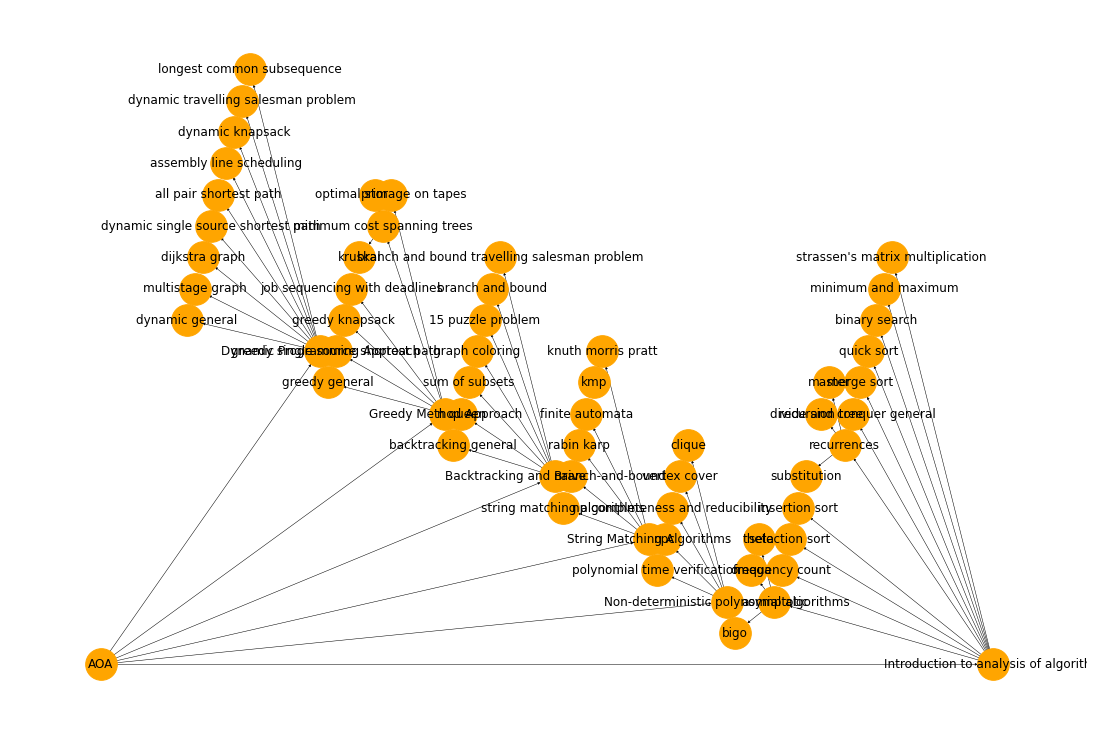

In [ ]:
plot_graph(G)

### Parse Qestion paper dataframe through graph and identify syllabus nodes
Output will be DataFrame with identified nodes

In [ ]:
parse(qp_df)

# Print output
qp_df

,Num,Question,Marks,Extracted Keywords,Identified Node
0,1a,Derive the complexity of quick sort for best c...,5,quick sort best case worst,quick sort
1,1b,What is asymptotic analysis? Define BigO. Omeg...,5,asymptotic bigo omega theta notation,asymptotic
2,1c,Write an algorithm to find all pairs shortest ...,5,pair shortest path dynamic,all pair shortest path
3,1d,"Write a note on ""Optimal Storage on Tapes"".",5,optimal storage tape,optimal storage on tapes
4,1e,Define master theorem.,5,master theorem,master
5,2a,Write an algorithm for finding minimum and max...,10,minimum maximum divide conquer,minimum and maximum
6,2b,Write Kruskal's algorithm.,10,kruskal,kruskal
7,3a,Solve fractional knapsack problem for the foll...,10,fractional knapsack,None
8,3b,Write an algorithm for Knuth Morris Pratt (KMP...,10,knuth morris pratt kmp pattern matching,knuth morris pratt
9,4a,Write an algorithm to solve N Queens problem. ...,10,n queen working,n queen


## Extraction of Bloom verbs from questions
Output will be dataframe containing extracted Bloom's verbs

In [ ]:
get_bloom_tagged(qp_df)

,Num,Question,Marks,Extracted Keywords,Identified Node,Bloom's Verbs
0,1a,Derive the complexity of quick sort for best c...,5,quick sort best case worst,quick sort,"[(derive, apply)]"
1,1b,What is asymptotic analysis? Define BigO. Omeg...,5,asymptotic bigo omega theta notation,asymptotic,"[(define, remember)]"
2,1c,Write an algorithm to find all pairs shortest ...,5,pair shortest path dynamic,all pair shortest path,"[(write, remember)]"
3,1d,"Write a note on ""Optimal Storage on Tapes"".",5,optimal storage tape,optimal storage on tapes,"[(write, remember)]"
4,1e,Define master theorem.,5,master theorem,master,"[(define, remember)]"
5,2a,Write an algorithm for finding minimum and max...,10,minimum maximum divide conquer,minimum and maximum,"[(write, remember), (derive, apply)]"
6,2b,Write Kruskal's algorithm.,10,kruskal,kruskal,"[(write, remember)]"
7,3a,Solve fractional knapsack problem for the foll...,10,fractional knapsack,None,"[(solve, apply)]"
8,3b,Write an algorithm for Knuth Morris Pratt (KMP...,10,knuth morris pratt kmp pattern matching,knuth morris pratt,"[(write, remember)]"
9,4a,Write an algorithm to solve N Queens problem. ...,10,n queen working,n queen,"[(write, remember), (solve, apply), (show, app..."


## Calculate Syllabus Fairness Score and Bloom's Taxonomy Score based on identified nodes and extracted bloom's verbs

In [ ]:
print('Syllabus Fairness Score: '+str(get_result()))
print("Bloom's Taxonomy Score: "+str(get_final_bloom_score(qp_df)))

Syllabus Fairness Score: 83.45
Bloom's Taxonomy Score: 10.64


### Bloom's Score per question on 0 to 1 scale

In [ ]:
qp_df

,Num,Question,Marks,Extracted Keywords,Identified Node,Bloom's Verbs,Bloom's Score
0,1a,Derive the complexity of quick sort for best c...,5,quick sort best case worst,quick sort,"[(derive, apply)]",0.142857
1,1b,What is asymptotic analysis? Define BigO. Omeg...,5,asymptotic bigo omega theta notation,asymptotic,"[(define, remember)]",0.047619
2,1c,Write an algorithm to find all pairs shortest ...,5,pair shortest path dynamic,all pair shortest path,"[(write, remember)]",0.047619
3,1d,"Write a note on ""Optimal Storage on Tapes"".",5,optimal storage tape,optimal storage on tapes,"[(write, remember)]",0.047619
4,1e,Define master theorem.,5,master theorem,master,"[(define, remember)]",0.047619
5,2a,Write an algorithm for finding minimum and max...,10,minimum maximum divide conquer,minimum and maximum,"[(write, remember), (derive, apply)]",0.190476
6,2b,Write Kruskal's algorithm.,10,kruskal,kruskal,"[(write, remember)]",0.047619
7,3a,Solve fractional knapsack problem for the foll...,10,fractional knapsack,None,"[(solve, apply)]",0.142857
8,3b,Write an algorithm for Knuth Morris Pratt (KMP...,10,knuth morris pratt kmp pattern matching,knuth morris pratt,"[(write, remember)]",0.047619
9,4a,Write an algorithm to solve N Queens problem. ...,10,n queen working,n queen,"[(write, remember), (solve, apply), (show, app...",0.333333


In [ ]:
display()

AOA 145 121 14
Introduction to analysis of algorithm 36 25 0
Dynamic Programming Approach 24 24 1
Greedy Method Approach 18 18 7
Backtracking and Branch-and-bound 24 24 6
String Matching Algorithms 18 10 0
Non-deterministic polynomial algorithms 24 20 0
asymptotic 10 5 0
bigo 10 0 0
omega 10 0 0
theta 10 0 0
frequency count 10 0 0
selection sort 10 0 0
insertion sort 10 0 0
recurrences 10 5 0
substitution 10 0 0
recursion tree 10 0 0
master 10 5 0
divide and conquer general 10 0 0
merge sort 10 0 0
quick sort 10 5 0
binary search 10 0 0
minimum and maximum 10 10 0
strassen's matrix multiplication 10 0 0
dynamic general 10 0 0
multistage graph 10 0 0
dijkstra graph 10 0 0
dynamic single source shortest path 10 0 0
all pair shortest path 10 5 0
assembly line scheduling 10 10 0
dynamic knapsack 10 0 0
dynamic travelling salesman problem 10 0 0
longest common subsequence 10 10 0
greedy general 10 0 0
greedy single source shortest path 10 0 0
greedy knapsack 10 0 0
job sequencing with deadl